In [1]:
from sklearn.cluster import KMeans
from matplotlib import colors
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
from collections import defaultdict
import image_slicer
import os

Structure of this program:
1. Import an image
2. Change it to an np array
3. Reduce color
4. Slice
5. Identify blocks
6. Construct a map based on the identified blocks

In [1]:
def RGB2HEX(color):
    '''rgb to hex converter'''
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def reduce_colors(image, n_colors):
    '''reduce the number of colors presented in a image'''
    arr = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(arr)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    fewer_colors = centers[labels].reshape(image.shape).astype('uint8')
    return fewer_colors

def slicer(image, row, col):
    '''slice a image into row*col 2d array of subimages'''
    apc=[]
    for r in range(0,image.shape[0],image.shape[0]//row):
        for c in range(0,image.shape[1],image.shape[1]//col):
            apc.append(image[r:r+image.shape[0]//row, c:c+image.shape[1]//col,:])
    if apc[-1].shape[0]==apc[0].shape[0] and apc[-1].shape[1]==apc[0].shape[1]:
        return [apc[i:i+row] for i in range(0, len(apc), row)]
    else:
        newapc=[]
        while len(apc)>0:
            newapc=newapc+apc[0:col]
            apc=apc[col+1:]
        newapc=newapc[:row*col]
        return [newapc[i:i+row] for i in range(0, len(newapc), row)]
    
def identify_land(image):
    '''identify the land type of an image'''
    height=len(image)
    width=len(image[0])
    water1='#16b2b0'
    water2='#155bdc' 
    tree='#177237' 
    crop='#745617'
    colordict=defaultdict(int)
    for i in image:
        for j in i:
            colordict[RGB2HEX(j)]+=1
    wratio=(colordict[water1]+colordict[water2])/(height*width)
    tratio=colordict[tree]/(height*width)
    cratio=colordict[crop]/(height*width)
    if cratio>0.1:
        return 2
    elif wratio>0.8:
        return 0
    elif tratio>0.18:
        return 1

def Process(fpath, row, col):
    '''output crop, water and tree blocks given an image'''
    image = cv2.imread(fpath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image=reduce_colors(image, 9)
    subimages=slicer(image, row, col)
    waterset=set()
    cropset=set()
    treeset=set()
    for i in range(0, len(subimages)):
        for j in range(0, len(subimages[i])):
            if identify_land(subimages[i][j])==2:
                cropset.add((i,j))
            elif identify_land(subimages[i][j])==0:
                waterset.add((i,j))
            elif  identify_land(subimages[i][j])==1:
                treeset.add((i,j))
    return cropset, waterset, treeset

def generate_map(rows, cols, cropset=None, waterset=None, treeset=None, protectset=None):
    '''Generate a lattice map'''
    arr=[] 
    for i in range(cols): 
        col = [] 
        for j in range(rows): 
            col.append(0) 
        arr.append(col)
    if cropset!=None:
        for i in cropset:
            arr[i[0]][i[1]]=3
    if waterset!=None:
        for i in waterset:
            arr[i[0]][i[1]]=2
    if treeset!=None:
        for i in treeset:
            arr[i[0]][i[1]]=1
    return np.array(arr)

def plot_map(row, col, cropset, waterset, treeset):
    data = generate_map(row, col, cropset, waterset, treeset)
    # create discrete colormap
    cmap = colors.ListedColormap(['white', 'green', 'blue', 'orange'])
    bounds = [0,1,2,3,4]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(data, cmap=cmap, norm=norm)
    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
    ax.set_xticks(np.arange(0, col, 1));
    ax.set_yticks(np.arange(0, row, 1));
    plt.show()

In [169]:
cropset, waterset,treeset=Process(fpath,16,16)

The code below outputs the origial map, a map with "resolution" 16\*16, a map with "resolution" 20\*20, and a map with "resolution" 30\*30.  

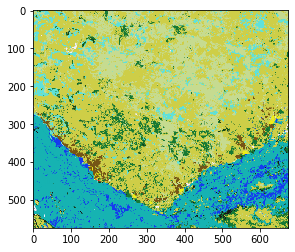

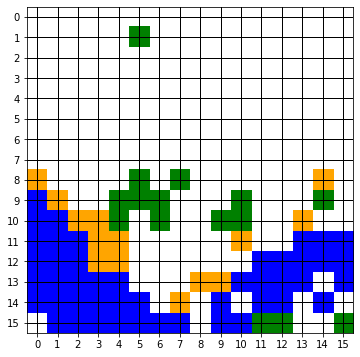

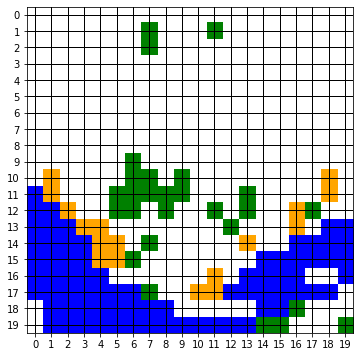

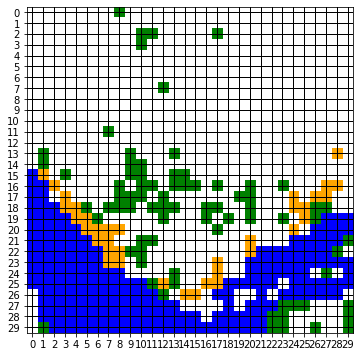

In [172]:
image = cv2.imread('C:\\Users\\s1760\\Desktop\\ok\\Okavango.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
cropset, waterset,treeset=Process(fpath,16,16)
plot_map(16,16,cropset,waterset,treeset)
cropset, waterset,treeset=Process(fpath,20,20)
plot_map(20,20,cropset,waterset,treeset)
cropset, waterset,treeset=Process(fpath,30,30)
plot_map(30,30,cropset,waterset,treeset)